## Quora question pairs: Deep learning

In [1]:
# import statements
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Input, concatenate, dot, Flatten, Reshape, Bidirectional, add
from keras.layers import TimeDistributed, Lambda
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.regularizers import l2
from keras.layers import dot, Dot
from keras.activations import softmax
from keras.layers import Permute, subtract, multiply, GlobalAvgPool1D, GlobalMaxPool1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Adadelta
import keras.backend as K
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.preprocessing import sequence, text
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
import functions.utils as utils
from functions.utils import *
import models.deep_learning as deep_learning
from models.deep_learning import *
from functions.model_evaluation import *
import functions.model_evaluation
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
#Loading the data
df = pd.read_csv('Data/train.csv')
df['question1'] = df['question1'].apply(str)
df['question2'] = df['question2'].apply(str)
df.dropna(inplace = True)
#df = df[:30000]

In [3]:
def write_csv(result, id_col, path):
    result_final = pd.DataFrame(data = list(zip(id_col, result)), columns = ['id', 'prediction'])
    result_final.to_csv(path, index = False)

In [4]:
#training and testing
seed = 123
train, test = train_test_split(df)
q = list(train['question1']) + list(train['question2']) + list(test['question1']) + list(test['question2'])

In [5]:
#loading the word vector
file_name = 'word_embedding/glove.6B.300d.txt'
embeddings = load_embedding(file_name)

In [6]:
#Creating the embedding matrix
NUM_WORDS = len(embeddings) #200000
tokenize = Tokenizer(num_words = NUM_WORDS)
tokenize.fit_on_texts(q)
word_index = tokenize.word_index

q1_train = tokenize.texts_to_sequences(train['question1'])
q2_train = tokenize.texts_to_sequences(train['question2'])
q1_test = tokenize.texts_to_sequences(test['question1'])
q2_test = tokenize.texts_to_sequences(test['question2'])

max_seq_length = max_seq_len(q1_train)
max_seq_length = max_seq_len(q2_train, max_seq_length)
max_seq_length = max_seq_len(q1_test, max_seq_length)
max_seq_length = max_seq_len(q2_test, max_seq_length)

q1_train_padded = pad_sequences(q1_train, max_seq_length)
q2_train_padded = pad_sequences(q2_train, max_seq_length)
q1_test_padded = pad_sequences(q1_test, max_seq_length)
q2_test_padded = pad_sequences(q2_test, max_seq_length)
#Matrix with the embedding weights
embedding_dim = 300
embedding_weights = create_embedding_weights(embeddings, embedding_dim, word_index, NUM_WORDS)
NUM_WORDS = len(embedding_weights)
NUM_WORDS

95597

## Deep learning models

In [9]:
dl = deep_learning.deepModels(embedding_dim = embedding_dim,
                embedding_weights = embedding_weights,
                max_seq_length = max_seq_length,
                NUM_WORDS = NUM_WORDS)

### Siamese LSTM

In [14]:
lstm = dl.siamese_lstm(dropout_lstm=None)

In [15]:
batch_size=100
epochs=15
validation_split=.1

In [16]:
hist_lstm = lstm.fit([q1_train_padded, q2_train_padded],
                     train['is_duplicate'],
                     batch_size=100, epochs=15, 
                     validation_split=.1)

Train on 272895 samples, validate on 30322 samples
Epoch 1/15
272895/272895 [==============================] - 1305s 5ms/step - loss: 0.4709 - accuracy: 0.7676 - val_loss: 0.4202 - val_accuracy: 0.8004
Epoch 2/15
272895/272895 [==============================] - 1367s 5ms/step - loss: 0.3793 - accuracy: 0.8235 - val_loss: 0.4031 - val_accuracy: 0.8110
Epoch 3/15
272895/272895 [==============================] - 1379s 5ms/step - loss: 0.3268 - accuracy: 0.8530 - val_loss: 0.3980 - val_accuracy: 0.8232
Epoch 4/15
272895/272895 [==============================] - 1381s 5ms/step - loss: 0.2801 - accuracy: 0.8775 - val_loss: 0.3761 - val_accuracy: 0.8382
Epoch 5/15
272895/272895 [==============================] - 1370s 5ms/step - loss: 0.2398 - accuracy: 0.8983 - val_loss: 0.3841 - val_accuracy: 0.8382
Epoch 6/15
272895/272895 [==============================] - 1373s 5ms/step - loss: 0.2020 - accuracy: 0.9153 - val_loss: 0.4155 - val_accuracy: 0.8355
Epoch 7/15
272895/272895 [=================

In [17]:
pred_lstm = lstm.predict([q1_test_padded, q2_test_padded])

In [18]:
result_lstm = []
for i in pred_lstm:
    if i > .5:
        result_lstm.append(1)
    else:
        result_lstm.append(0)
        
count = 0
for i in range(len(result_lstm)):
    if result_lstm[i] == test['is_duplicate'].to_numpy()[i]:
        count = count +1

accuracy = (count/len(result_lstm))*100


In [19]:
print('accuracy:'+ str(accuracy))

accuracy:84.15105913547633


In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [21]:
print('f1_socre:' + str(f1_score(test['is_duplicate'], result_lstm, average = 'weighted')))
print('recall_socre:' + str(recall_score(test['is_duplicate'], result_lstm, average = 'weighted')))
print('precision_socre:' + str(precision_score(test['is_duplicate'], result_lstm, average = 'weighted')))

f1_socre:0.8403936988573176
recall_socre:0.8415105913547634
precision_socre:0.840212986973901


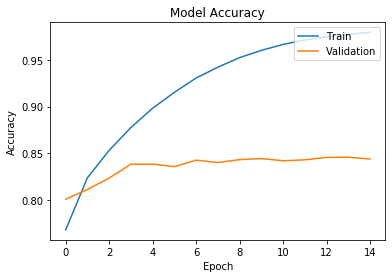

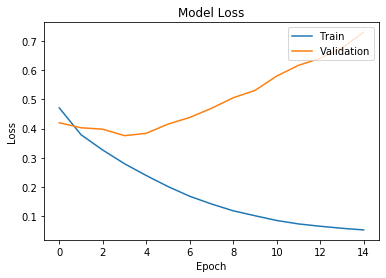

In [22]:
plot_model_training(hist_lstm)

In [41]:
write_csv(result_lstm, test['id'], 'results/deep_learning/quora/lstm.csv')

### Siamese GRU

In [23]:
gru = dl.Siamese_GRU()

In [24]:
batch_size=100
epochs=15
validation_split=.1

In [25]:
hist_gru = gru.fit([q1_train_padded, 
                    q2_train_padded],
                   train['is_duplicate'],
                   batch_size=batch_size,
                   epochs=epochs, 
                   validation_split=validation_split)

Train on 272895 samples, validate on 30322 samples
Epoch 1/15
272895/272895 [==============================] - 1651s 6ms/step - loss: 0.4642 - accuracy: 0.7718 - val_loss: 0.4149 - val_accuracy: 0.8027
Epoch 2/15
272895/272895 [==============================] - 1638s 6ms/step - loss: 0.3799 - accuracy: 0.8235 - val_loss: 0.3821 - val_accuracy: 0.8230
Epoch 3/15
272895/272895 [==============================] - 1636s 6ms/step - loss: 0.3385 - accuracy: 0.8464 - val_loss: 0.3759 - val_accuracy: 0.8284
Epoch 4/15
272895/272895 [==============================] - 1654s 6ms/step - loss: 0.3002 - accuracy: 0.8677 - val_loss: 0.3631 - val_accuracy: 0.8365
Epoch 5/15
272895/272895 [==============================] - 1680s 6ms/step - loss: 0.2662 - accuracy: 0.8841 - val_loss: 0.3642 - val_accuracy: 0.8399
Epoch 6/15
272895/272895 [==============================] - 1710s 6ms/step - loss: 0.2311 - accuracy: 0.9024 - val_loss: 0.3943 - val_accuracy: 0.8358
Epoch 7/15
272895/272895 [=================

In [26]:
pred_gru = gru.predict([q1_test_padded, q2_test_padded])

In [27]:
result_gru = []
for i in pred_gru:
    if i > .5:
        result_gru.append(1)
    else:
        result_gru.append(0)
        
count = 0
for i in range(len(result_gru)):
    if result_gru[i] == test['is_duplicate'].to_numpy()[i]:
        count = count +1

accuracy = (count/len(result_gru))*100
accuracy

83.87699979222938

In [28]:
print('f1_socre:' + str(f1_score(test['is_duplicate'], result_gru, average = 'weighted')))
print('recall_socre:' + str(recall_score(test['is_duplicate'], result_gru, average = 'weighted')))
print('precision_socre:' + str(precision_score(test['is_duplicate'], result_gru, average = 'weighted')))

f1_socre:0.8381912620598515
recall_socre:0.8387699979222938
precision_socre:0.8378743919963506


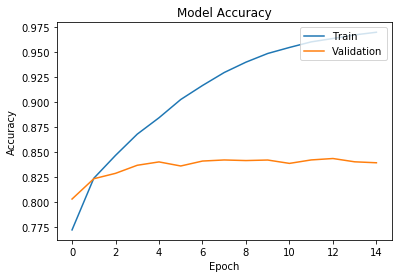

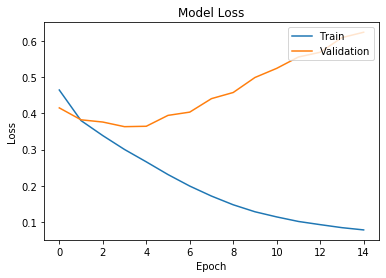

In [29]:
plot_model_training(hist_gru)

In [40]:
write_csv(result_gru, test['id'], 'results/deep_learning/quora/gru.csv')

### Siamese CNN

In [7]:
from importlib import reload
reload(deep_learning)

<module 'models.deep_learning' from 'C:\\Users\\hkpat\\Masters\\NLP\\NLI_project\\models\\deep_learning.py'>

In [7]:
batch_size = 100
epochs = 15
validation_split = 0.1

In [47]:
cnn = dl.siamese_cnn(filters= 16, kernel_size= 3)

In [48]:
hist_cnn = cnn.fit([q1_train_padded, q2_train_padded], 
                   train['is_duplicate'], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_split=validation_split)

Train on 272895 samples, validate on 30322 samples
Epoch 1/15
272895/272895 [==============================] - 35s 129us/step - loss: 0.5658 - accuracy: 0.6976 - val_loss: 0.5419 - val_accuracy: 0.7155
Epoch 2/15
272895/272895 [==============================] - 35s 129us/step - loss: 0.5255 - accuracy: 0.7287 - val_loss: 0.5260 - val_accuracy: 0.7295
Epoch 3/15
272895/272895 [==============================] - 35s 130us/step - loss: 0.5070 - accuracy: 0.7412 - val_loss: 0.5232 - val_accuracy: 0.7323
Epoch 4/15
272895/272895 [==============================] - 35s 129us/step - loss: 0.4943 - accuracy: 0.7499 - val_loss: 0.5206 - val_accuracy: 0.7328
Epoch 5/15
272895/272895 [==============================] - 35s 130us/step - loss: 0.4838 - accuracy: 0.7565 - val_loss: 0.5183 - val_accuracy: 0.7347
Epoch 6/15
272895/272895 [==============================] - 35s 129us/step - loss: 0.4756 - accuracy: 0.7618 - val_loss: 0.5164 - val_accuracy: 0.7402
Epoch 7/15
272895/272895 [=================

In [49]:
pred_cnn = cnn.predict([q1_test_padded, q2_test_padded])

In [50]:
result_cnn = []
for i in pred_cnn:
    if i > .5:
        result_cnn.append(1)
    else:
        result_cnn.append(0)
        
count = 0
for i in range(len(result_cnn)):
    if result_cnn[i] == test['is_duplicate'].to_numpy()[i]:
        count = count +1

accuracy = (count/len(result_cnn))*100
accuracy

73.63786570102798

In [51]:
print('f1_socre:' + str(f1_score(test['is_duplicate'], result_cnn, average = 'weighted')))
print('recall_socre:' + str(recall_score(test['is_duplicate'], result_cnn, average = 'weighted')))
print('precision_socre:' + str(precision_score(test['is_duplicate'], result_cnn, average = 'weighted')))

f1_socre:0.7327291143476733
recall_socre:0.7363786570102797
precision_socre:0.731760708697558


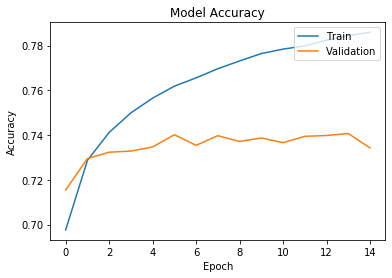

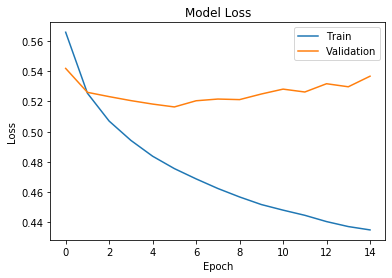

In [54]:
plot_model_training(hist_cnn)

In [53]:
write_csv(result_cnn, test['id'], 'results/deep_learning/quora/cnn.csv')

#### SNLI Benchmark

In [50]:
from importlib import reload
reload(deep_learning)

<module 'deep_learning' from 'C:\\Users\\hkpat\\Masters\\NLP\\project_quora\\deep_learning.py'>

In [31]:
batch_size = 100
epochs = 15
validation_split = 0.1

In [32]:
snli = dl.deep_nn()

In [33]:
hist_snli = snli.fit([q1_train_padded, q2_train_padded], 
                   train['is_duplicate'], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_split=validation_split)

Train on 272895 samples, validate on 30322 samples
Epoch 1/15
272895/272895 [==============================] - 263s 965us/step - loss: 0.5493 - accuracy: 0.7175 - val_loss: 0.6614 - val_accuracy: 0.7236
Epoch 2/15
272895/272895 [==============================] - 259s 948us/step - loss: 0.4789 - accuracy: 0.7639 - val_loss: 0.4780 - val_accuracy: 0.7681
Epoch 3/15
272895/272895 [==============================] - 255s 933us/step - loss: 0.4463 - accuracy: 0.7834 - val_loss: 0.4655 - val_accuracy: 0.7711
Epoch 4/15
272895/272895 [==============================] - 261s 958us/step - loss: 0.4230 - accuracy: 0.7975 - val_loss: 0.5069 - val_accuracy: 0.7691
Epoch 5/15
272895/272895 [==============================] - 263s 965us/step - loss: 0.4028 - accuracy: 0.8089 - val_loss: 0.4323 - val_accuracy: 0.7899
Epoch 6/15
272895/272895 [==============================] - 259s 949us/step - loss: 0.3857 - accuracy: 0.8196 - val_loss: 0.4380 - val_accuracy: 0.7856
Epoch 7/15
272895/272895 [===========

In [34]:
pred_snli = snli.predict([q1_test_padded, q2_test_padded])

In [35]:
result_snli = []
for i in pred_snli:
    if i > .5:
        result_snli.append(1)
    else:
        result_snli.append(0)
        
count = 0
for i in range(len(result_snli)):
    if result_snli[i] == test['is_duplicate'].to_numpy()[i]:
        count = count +1

accuracy = (count/len(result_snli))*100
accuracy

78.92810147121388

In [36]:
print('f1_socre:' + str(f1_score(test['is_duplicate'], result_snli, average = 'weighted')))
print('recall_socre:' + str(recall_score(test['is_duplicate'], result_snli, average = 'weighted')))
print('precision_socre:' + str(precision_score(test['is_duplicate'], result_snli, average = 'weighted')))

f1_socre:0.7889975326892532
recall_socre:0.7892810147121387
precision_socre:0.7887502765958848


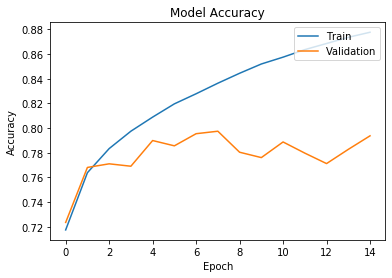

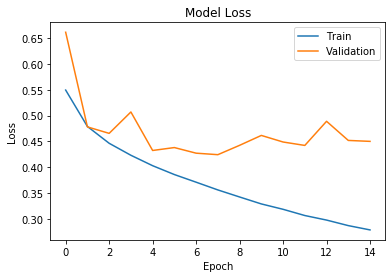

In [37]:
plot_model_training(hist_snli)

In [39]:
write_csv(result_snli, test['id'], 'results/deep_learning/quora/deep_nn.csv')

### Hybrid CNN-LSTM

In [12]:
batch_size = 100
epochs = 15
validation_split = 0.1

In [13]:
hybrid = dl.hybrid_model()

In [1]:
hist_hybrid = hybrid.fit([q1_train_padded, q2_train_padded], 
                   train['is_duplicate'], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_split=validation_split)

In [ ]:
pred_hybrid = hybrid.predict([q1_test_padded, q2_test_padded])

In [55]:
result_hybrid = []
for i in pred_hybrid:
    if i > .5:
        result_hybrid.append(1)
    else:
        result_hybrid.append(0)
        
count = 0
for i in range(len(result_hybrid)):
    if result_hybrid[i] == test['is_duplicate'].to_numpy()[i]:
        count = count +1

accuracy = (count/len(result_hybrid))*100
accuracy

67.65407180948424

In [57]:
print('f1_socre:' + str(f1_score(test['is_duplicate'], result_hybrid, average = 'weighted')))
print('recall_socre:' + str(recall_score(test['is_duplicate'], result_hybrid, average = 'weighted')))
print('precision_socre:' + str(precision_score(test['is_duplicate'], result_hybrid, average = 'weighted')))

f1_socre:0.6382799175808994
recall_socre:0.6765407180948424
precision_socre:0.6664569878422174


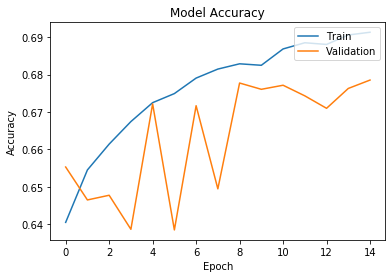

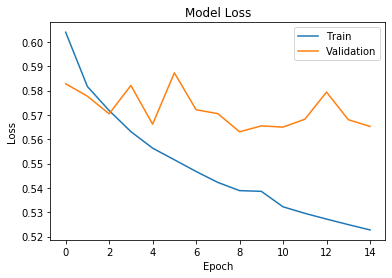

In [63]:
plot_model_training(hist_hybrid)

In [ ]:
write_csv(result_hybrid, test['id'], 'results/deep_learning/quora/hybrid.csv')

In [64]:
import gc

In [66]:
gc.collect()

35180

In [67]:
from keras import backend as K
K.clear_session()

In [68]:
from numba import cuda
cuda.select_device(0)
cuda.close()

### Enahnced LSTM

In [7]:
e_lstm = dl.enhanced_lstm()

In [8]:
batch_size = 32
epochs = 5
validation_split = .1

In [9]:
hist_e_lstm = e_lstm.fit([q1_train_padded, q2_train_padded], 
                   train['is_duplicate'], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_split=validation_split)

Train on 272895 samples, validate on 30322 samples
Epoch 1/5
272895/272895 [==============================] - 21709s 80ms/step - loss: 0.4735 - accuracy: 0.7615 - val_loss: 0.7410 - val_accuracy: 0.6571
Epoch 2/5
272895/272895 [==============================] - 20977s 77ms/step - loss: 0.4177 - accuracy: 0.7967 - val_loss: 0.4679 - val_accuracy: 0.7587
Epoch 3/5
272895/272895 [==============================] - 21666s 79ms/step - loss: 0.3983 - accuracy: 0.8098 - val_loss: 0.3908 - val_accuracy: 0.8133
Epoch 4/5
272895/272895 [==============================] - 20052s 73ms/step - loss: 0.3819 - accuracy: 0.8194 - val_loss: 0.4106 - val_accuracy: 0.7985
Epoch 5/5
272895/272895 [==============================] - 20132s 74ms/step - loss: 0.3715 - accuracy: 0.8249 - val_loss: 0.3782 - val_accuracy: 0.8240


In [10]:
pred_e_lstm = e_lstm.predict([q1_test_padded, q2_test_padded])

In [12]:
result_elstm = []
for i in pred_e_lstm:
    if i > .5:
        result_elstm.append(1)
    else:
        result_elstm.append(0)
        
count = 0
for i in range(len(result_elstm)):
    if result_elstm[i] == test['is_duplicate'].to_numpy()[i]:
        count = count +1

accuracy = (count/len(result_elstm))*100
accuracy

82.64422743957338

In [13]:
print('f1_socre:' + str(f1_score(test['is_duplicate'], result_elstm, average = 'weighted')))
print('recall_socre:' + str(recall_score(test['is_duplicate'], result_elstm, average = 'weighted')))
print('precision_socre:' + str(precision_score(test['is_duplicate'], result_elstm, average = 'weighted')))

f1_socre:0.8267826197007425
recall_socre:0.8264422743957338
precision_socre:0.8272131047165454


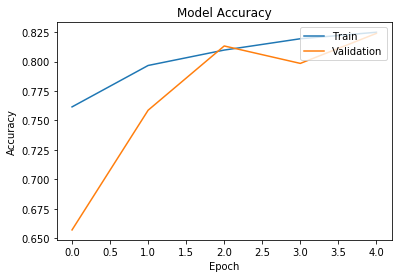

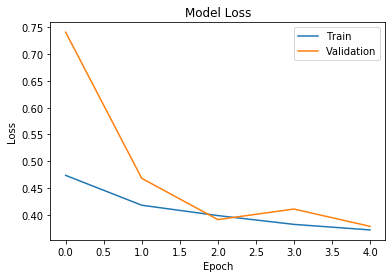

In [15]:
plot_model_training(hist_e_lstm)

In [38]:
write_csv(result_elstm, test['id'], 'results/deep_learning/quora/elstm.csv')